In [1]:
import json
import glob
import dateutil
import datetime
import tensorflow as _
import tensorflow_addons as tfa

import keras as _

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import timedelta
from tqdm import trange

from keras.layers import Input, Bidirectional, LSTM, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

2021-11-12 15:22:04.877653: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
current_time = datetime.datetime.now().strftime('%Y%m%d%H%M%S')

# 0. 기본 데이터셋 가져오기

In [3]:
train_raw = None

for p in glob.glob('train/*.csv'):
    data = pd.read_csv(p)
    if train_raw is None:
        train_raw = data
        continue
    train_raw = pd.concat([train_raw, data])

In [4]:
train_raw

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-08-06 09:00:01,-1.9192,0,12.24670,-0.00094,100.73242,0.3910,12.75681,70,1,...,1.18118,35.46829,6.34956,3177.11230,294.46979,1,993.42383,12.0,50,569
1,2021-08-06 09:00:02,-2.7392,0,12.24670,0.00065,100.73242,0.0073,12.75681,70,1,...,1.18118,35.46371,6.34956,3182.61768,294.90381,1,993.42383,12.0,50,5
2,2021-08-06 09:00:03,-2.5925,0,12.25433,-0.00217,100.73242,0.2805,12.75681,70,1,...,1.18042,35.46448,6.34956,3182.74292,298.43024,1,993.42383,12.0,50,5
3,2021-08-06 09:00:04,-2.5925,0,12.23907,0.00130,100.73242,0.2805,12.75681,70,1,...,1.17889,35.45341,6.34956,3179.48975,301.61316,1,993.42383,12.0,50,5
4,2021-08-06 09:00:05,-2.5495,0,12.24670,-0.00145,100.74005,0.0574,12.75681,70,1,...,1.18195,35.47287,6.34956,3177.11230,309.10010,1,993.42383,12.0,50,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201595,2021-07-19 07:59:56,-0.9169,0,12.09412,-0.00058,12.30774,1.7078,12.81139,70,1,...,1.23917,29.09280,6.86263,810.03571,351.27313,1,1001.02356,12.0,50,32
201596,2021-07-19 07:59:57,-0.9169,0,12.09412,-0.00058,12.26959,1.7078,12.81139,70,1,...,1.24069,29.10196,6.86263,775.80396,350.36890,1,1001.02356,12.0,50,33
201597,2021-07-19 07:59:58,-0.6298,0,12.09412,-0.00051,12.60528,1.7762,12.81139,70,1,...,1.23764,29.12218,6.86263,657.62598,349.42853,1,1001.02356,12.0,50,40
201598,2021-07-19 07:59:59,-0.4378,0,12.09412,0.00275,14.46686,2.0562,12.81139,70,1,...,1.23764,29.12294,6.86263,596.05432,346.84247,1,1001.02356,12.0,50,35


In [5]:
TIMESTAMP_FIELD = 'timestamp'
ATTACK_FIELD = 'attack'

train_raw_ts = train_raw[TIMESTAMP_FIELD]
train_col = train_raw.columns.drop([TIMESTAMP_FIELD])
train_df = train_raw.drop([TIMESTAMP_FIELD], axis=1)

# 1. 상관관계 기반 Feature set 분석 및 데이터셋 생성

In [6]:
_corr = train_raw.corr()

In [7]:
except_features = []
low_corr_features = []
is_except_element = []

In [8]:
for c in _corr.columns:
    if not (len(np.unique(_corr[c] >= 0.7)) == 1 and len(np.unique(_corr[c] <= -0.7)) == 1):
        except_features.append(c)
    else:
        low_corr_features.append(c)

print(f"Except Features: {except_features}")
print(f"Low-releated Features: {low_corr_features}")

Except Features: ['C01', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C20', 'C21', 'C23', 'C24', 'C25', 'C27', 'C28', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C37', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C50', 'C51', 'C53', 'C54', 'C56', 'C57', 'C58', 'C59', 'C60', 'C61', 'C62', 'C64', 'C65', 'C66', 'C67', 'C68', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80', 'C81', 'C83', 'C84', 'C86']
Low-releated Features: ['C02', 'C09', 'C10', 'C18', 'C19', 'C22', 'C26', 'C29', 'C36', 'C38', 'C39', 'C49', 'C52', 'C55', 'C63', 'C69', 'C82', 'C85']


In [9]:
def normalize(df, tag_min, tag_max):
    ndf = df.copy()
    for c in df.columns:
        if tag_min[c] == tag_max[c]:
            ndf[c] = df[c] - tag_min[c]
        else:
            ndf[c] = (df[c] - tag_min[c]) / (tag_max[c] - tag_min[c])
    return ndf


def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [10]:
WINDOW_GIVEN = 59
WINDOW_SIZE= 60

class HaiDataset():
    def __init__(self, timestamps, df, stride=1, attacks=None, given=WINDOW_GIVEN, size=WINDOW_SIZE):
        self.ts = np.array(timestamps)
        self.windows_given = given
        self.windows_size = size
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []

        for L in trange(len(self.ts) - size + 1):
            R = L + size - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(self.ts[L]) == timedelta(seconds=size - 1):
                self.valid_idxs.append(L)

        valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(valid_idxs)
        
        print("# of valid windows:", self.n_idxs)

        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.attacks = []
            self.with_attack = False
    
    def get_attack_set(self):
        attack_list = []
        if self.with_attack:
            for i in self.valid_idxs:
                last = i + self.windows_size - 1
                attack_list.append(self.attacks[last])
            return np.array(attack_list)
        else:
            return np.array([])

    def get_ts_set(self):
        timestamp = []
        for i in self.valid_idxs:
            last = i + self.windows_size - 1
            timestamp.append(self.ts[last])
        return np.array(timestamp)

    def get_train_set(self):
        X = []
        for i in self.valid_idxs:
            X.append(self.tag_values[i : i + self.windows_given])        
        return np.array(X)

    def get_label_set(self):
        y = []
        for i in self.valid_idxs:
            last = i + self.windows_size - 1
            y.append(self.tag_values[last])
        return np.array(y)

# 1-1. 상관관계가 높은 set를 가진 모델 생성 (학습을 이미 했다면 Pass!)

In [11]:
spec_tag_min = train_df[except_features].min()
spec_tag_max = train_df[except_features].max()

In [12]:
norm_spec_df = normalize(train_df[except_features], spec_tag_min, spec_tag_max)
norm_spec_df = norm_spec_df.ewm(alpha=0.9).mean()

In [13]:
spec_dataset = HaiDataset(train_raw[TIMESTAMP_FIELD], norm_spec_df, stride=1)
spec_ts = spec_dataset.get_ts_set()
spec_X = spec_dataset.get_train_set()
spec_y = spec_dataset.get_label_set()

100%|██████████| 1004343/1004343 [02:13<00:00, 7506.41it/s]


# of valid windows: 1004048


In [14]:
n_features = spec_X.shape[2]
inputs = Input(shape=(WINDOW_GIVEN, n_features))
first = Bidirectional(LSTM(100, return_sequences=True))(inputs)
second = Bidirectional(LSTM(100, return_sequences=True))(first)
third = Bidirectional(LSTM(100))(second)
gru_out = Dense(n_features)(third)

model = Model(inputs = inputs, outputs = gru_out)
model.compile(loss='mean_squared_error', optimizer=tfa.optimizers.RectifiedAdam())

2021-11-12 15:25:02.677362: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-12 15:25:02.678702: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-12 15:25:02.731461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2021-11-12 15:25:02.731494: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-12 15:25:02.763930: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-12 15:25:02.764034: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 59, 68)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 59, 200)           135200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 59, 200)           240800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense (Dense)                (None, 68)                13668     
Total params: 630,468
Trainable params: 630,468
Non-trainable params: 0
_________________________________________________________________


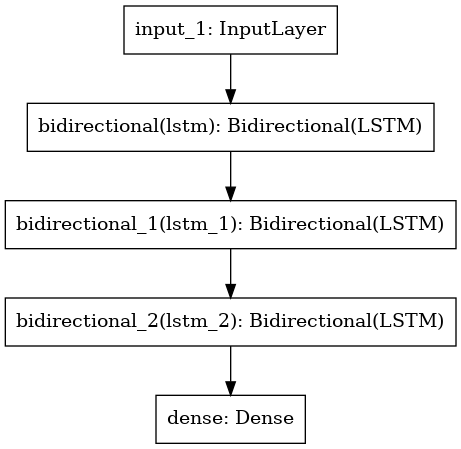

In [16]:
plot_model(model)

In [17]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(f'lstm_{WINDOW_GIVEN}_{n_features}_{current_time}.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)
history = model.fit(spec_X, spec_y, epochs=50, batch_size=2048, verbose=1, shuffle=True, callbacks=[es, mc])

2021-11-12 15:25:05.999919: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 16112962304 exceeds 10% of free system memory.
2021-11-12 15:25:19.702002: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-12 15:25:19.722870: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/50


2021-11-12 15:25:27.621718: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-12 15:25:28.426187: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


491/491 [==============================] - 62s 105ms/step - loss: 0.0761

Epoch 00001: loss improved from inf to 0.02530, saving model to lstm_59_68_20211112152207.h5
Epoch 2/50
491/491 [==============================] - 51s 104ms/step - loss: 0.0018

Epoch 00002: loss improved from 0.02530 to 0.00158, saving model to lstm_59_68_20211112152207.h5
Epoch 3/50
491/491 [==============================] - 51s 104ms/step - loss: 0.0012

Epoch 00003: loss improved from 0.00158 to 0.00104, saving model to lstm_59_68_20211112152207.h5
Epoch 4/50
491/491 [==============================] - 51s 103ms/step - loss: 7.9393e-04

Epoch 00004: loss improved from 0.00104 to 0.00076, saving model to lstm_59_68_20211112152207.h5
Epoch 5/50
491/491 [==============================] - 50s 103ms/step - loss: 6.8861e-04

Epoch 00005: loss improved from 0.00076 to 0.00067, saving model to lstm_59_68_20211112152207.h5
Epoch 6/50
491/491 [==============================] - 50s 103ms/step - loss: 6.2029e-04

Epoch 00

In [18]:
with open(f'lstm_window_{WINDOW_GIVEN}_{n_features}_{current_time}.h5.json', "w") as json_file:
    json.dump(history.history['loss'], json_file)

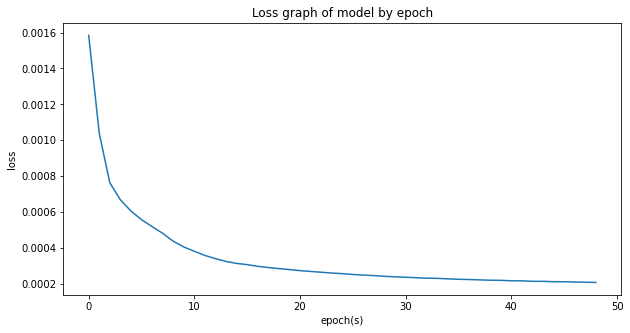

In [19]:
plt.figure(figsize=(10,5))
plt.plot(range(0, len(history.history['loss'][1:])), history.history['loss'][1:])
plt.title('Loss graph of model by epoch')
plt.xlabel("epoch(s)")
plt.ylabel("loss")
plt.show()

# 1-2. 상관관계와 관계없이 모든 Feature에 대한 모델 생성 (학습을 이미 했다면 Pass!)

In [20]:
tag_min = train_df.min()
tag_max = train_df.max()

In [21]:
norm_df = normalize(train_df, tag_min, tag_max)
norm_df = norm_df.ewm(alpha=0.9).mean()

In [22]:
dataset = HaiDataset(train_raw[TIMESTAMP_FIELD], norm_df, stride=1)
ts = dataset.get_ts_set()
X = dataset.get_train_set()
y = dataset.get_label_set()

100%|██████████| 1004343/1004343 [02:15<00:00, 7427.82it/s]


# of valid windows: 1004048


In [ ]:
n_features = X.shape[2]
inputs = Input(shape=(WINDOW_GIVEN, n_features))

first = Bidirectional(LSTM(100, return_sequences=True))(inputs)
second = Bidirectional(LSTM(100, return_sequences=True))(first)
third = Bidirectional(LSTM(100))(second)
gru_out = Dense(n_features)(third)

model = Model(inputs = inputs, outputs = gru_out)
model.compile(loss='mean_squared_error', optimizer=tfa.optimizers.RectifiedAdam())

In [ ]:
model.summary()

In [ ]:
plot_model(model)

In [ ]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(f'lstm_{WINDOW_GIVEN}_{n_features}_{current_time}.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)
history = model.fit(X, y, epochs=50, batch_size=2048, verbose=1, shuffle=True, callbacks=[es, mc])

In [ ]:
with open(f'lstm_window_{WINDOW_GIVEN}_{n_features}.h5.json', "w") as json_file:
    json.dump(history.history['loss'], json_file)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(0, len(history.history['loss'][1:])), history.history['loss'][1:])
plt.title('Loss graph of model by epoch')
plt.xlabel("epoch(s)")
plt.ylabel("loss")
plt.show()